<a href="https://colab.research.google.com/github/Tonyz4516/detector-for-masked-faces/blob/master/Classifier_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_embeddings = pd.read_csv("drive/My Drive/5500_Project/facenet_mask_detector/embarray_train.txt", sep=" ", header=None)
test_embeddings = pd.read_csv("drive/My Drive/5500_Project/facenet_mask_detector/embarray_test.txt", sep=" ", header=None)

In [4]:
train_labels = pd.read_csv("drive/My Drive/5500_Project/facenet_mask_detector/labels_train.txt", sep=" ", header=None)
test_labels = pd.read_csv("drive/My Drive/5500_Project/facenet_mask_detector/labels_test.txt", sep=" ", header= None)
train_labels.columns = ["label"]
test_labels.columns = ["label"]

In [5]:
print("training set images: ", train_embeddings.shape[0])
print("test set images: ", test_embeddings.shape[0])
print('embedding size: ', test_embeddings.shape[1])

training set images:  112571
test set images:  37428
embedding size:  512


In [7]:
# label == 1 means face with mask
print('training images with mask: ', train_labels[train_labels['label'] == 1].shape[0])
print('test images with mask: ', test_labels[test_labels['label'] == 1].shape[0])

training images with mask:  44403
test images with mask:  14942


# Classifier: SVM

In [ ]:
# load junmei's results here



In [8]:
# use SVM directly here 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics

X = train_embeddings.values
y = train_labels.values
X_test = test_embeddings.values
y_test = test_labels.values
acc = {}
train_acc = {}
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in tqdm(range(len(kernels))):
  kernel = kernels[i]
  svm = make_pipeline(StandardScaler(), SVC(kernel=kernel))
  svm.fit(X, y)
  y_hat = svm.predict(X_test)
  acc[kernel] = metrics.accuracy_score(y_test, y_hat)
  train_acc[kernel] = metrics.accuracy_score(y, svm.predict(X))
print(acc)
print(train_acc)



# Classifier: Logistic Regression

In [107]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

X = train_embeddings.values
y = train_labels.values
X_test = test_embeddings.values
y_test = test_labels.values
import time
start = time.time()
logreg = LogisticRegression(random_state=0).fit(X, y)
end = time.time()
print(end - start)
y_hat = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)
acc = logreg.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


8.754600763320923


In [8]:
|print('training accuracy: ',logreg.score(X, y))
print('test accuracy: ', acc)

training accuracy:  0.952119107052438
test accuracy:  0.9499305332905846


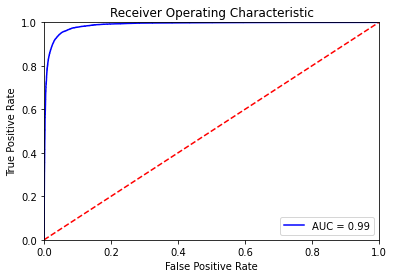

In [12]:
import sklearn.metrics as metrics
preds = y_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot roc curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [13]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,fpr,tpr,1-fpr,tf,thresholds
1711,0.050031,0.950007,0.949969,0.000038,0.402755


The result is quite balanced. The AUC is 0.99, the best threshold is 0.402755

## use L1 penalty and balanced class to see if it could help improve the performance

In [108]:
# use L1 norm
start = time.time()
logreg = LogisticRegression(random_state=0, penalty = 'l1', solver= 'saga').fit(X, y)
end = time.time()
print(end - start)
y_hat = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)
acc = logreg.score(X_test, y_test)
acc

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


98.73533821105957


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9510259698621353

In [18]:
acc_train = logreg.score(X, y)
acc_train

0.9532739337840118

In [15]:
logreg = LogisticRegression(random_state=0, penalty = 'l2', solver= 'saga').fit(X, y)
y_hat = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)
acc = logreg.score(X_test, y_test)
acc

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9499572512557444

In [16]:
acc_train = logreg.score(X, y)
acc_train

0.952119107052438

To compare the performance of l1 and l2 norm under same condition, we also run the model with solver = 'saga' for l2 norm. The accuracy shows that the l1 norm is a little bit better than l2 norm on both training and test set. 

In [9]:
# use balanced class weight

logreg = LogisticRegression(random_state=0, penalty = 'l2', solver= 'saga', class_weight='balanced').fit(X, y)
y_hat = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)
acc = logreg.score(X_test, y_test)
print('test acc: ', acc)
print('training acc: ', logreg.score(X, y))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test acc:  0.950010687186064
training acc:  0.9512485453624824


The best performance model is l1 penalty

# Classifier: NN

In [110]:
# ! pip install tensorflow==1.4
import tensorflow as tf

# Python optimisation variables
learning_rate = 0.05
epochs = 100
batch_size = 1000

# declare the training data placeholders
# input x - for 28 x 28 pixels = 784
x = tf.placeholder(tf.float32, [None, 512])
# now declare the output data placeholder - 2 digits
y = tf.placeholder(tf.float32, [None, 2])

In [109]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y)
y_nn = enc.transform(y).toarray()

y_nn = np.float32(y_nn)
y_nn.dtype

X = np.float32(X)
X.dtype

dtype('float32')

In [111]:
# now declare the weights connecting the input to the hidden layer
W1 = tf.Variable(tf.random_normal([512, 300], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([300]), name='b1')
# and the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random_normal([300, 2], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([2]), name='b2')

# calculate the output of the hidden layer
hidden_out = tf.add(tf.matmul(x, W1), b1)
hidden_out = tf.nn.relu(hidden_out)

# output layer
y_ = tf.nn.softmax(tf.add(tf.matmul(hidden_out, W2), b2))

In [112]:
y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)
                         + (1 - y) * tf.log(1 - y_clipped), axis=1))

# add an optimiser
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [113]:
# finally setup the initialisation operator
init_op = tf.global_variables_initializer()


# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [114]:
def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y

In [115]:
# start the session
start = time.time()
with tf.Session() as sess:
   # initialise the variables
   sess.run(init_op)
   total_batch = int(X.shape[0] / batch_size)
   
   for epoch in range(epochs):
        X, y_nn = randomize(X, y_nn)
        for i in range(total_batch):   
            batch_x, batch_y = X[i*batch_size:i*batch_size+batch_size], y_nn[i*batch_size:i*batch_size+batch_size]
            sess.run(optimiser, feed_dict={x: batch_x, y: batch_y})
        if epoch % 10 == 0:
            # Calculate and display the batch loss and accuracy
            acc_batch = sess.run(accuracy,feed_dict={x: batch_x, y: batch_y})

            print("Training Accuracy= %f" % acc_batch)
   end = time.time()
   print(end-start)
   print(sess.run(accuracy, feed_dict={x: X_test, y:y_nn_test}))

Training Accuracy= 0.622000
Training Accuracy= 0.949000
Training Accuracy= 0.952000
Training Accuracy= 0.933000
Training Accuracy= 0.960000
Training Accuracy= 0.950000
Training Accuracy= 0.958000
Training Accuracy= 0.955000
Training Accuracy= 0.961000
Training Accuracy= 0.968000
639.0544276237488
0.95572835


In [5]:
acc_test = {'Logistic regression(L2)': 0.950, 
            'Logistic regression(L1)': 0.951,
            'SVM linear':0.951,
  
            'SVM rbf':  0.943,
            'SVM sigmoid': 0.940 ,
            'NN': 0.957}

acc_train = {'Logistic regression(L2)': 0.952, 
            'Logistic regression(L1)': 0.953,
            'SVM linear':0.954,
           
            'SVM rbf':  0.945,
            'SVM sigmoid': 0.940 ,
            'NN': 0.969}


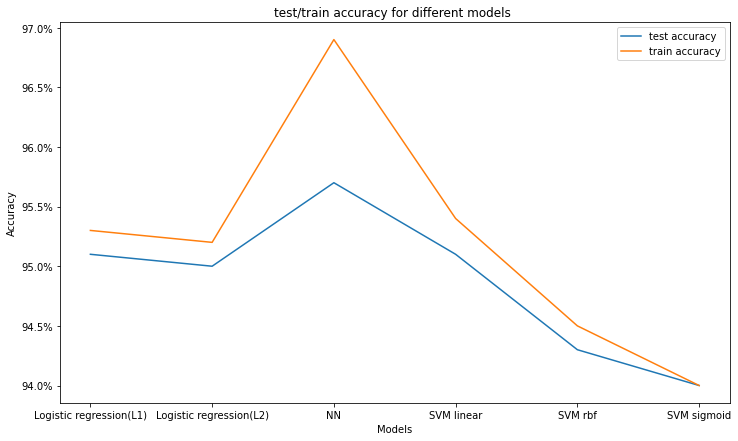

In [9]:
plt.figure(figsize= (12,7))

lists = sorted(acc_test.items()) # sorted by key, return a list of tuples
lists2 = sorted(acc_train.items())
x1, y1 = zip(*lists) # unpack a list of pairs into two tuples
x2, y2 = zip(*lists2)

plt.plot(x1, y1, label = "test accuracy")

plt.plot(x2, y2, label = "train accuracy")
plt.xlabel('Models')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy')
# Set a title of the current axes.
plt.title('test/train accuracy for different models ')

plt.gca().set_yticklabels(['{:.1f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()


Generally, all models give a quite good accuracy on this task. When we take the training time into consider, logistic regression is the fastest one with relatively good results. The NN performs best and training time is about couple of minutes which is acceptable.

# Next Step
## what to improve
* wrong classification analysis (what kind of images are classified wrong)
* bias or variance
## how to improve
* more data
* remove wrong data
* more complex model
* regularization


